In [164]:
import pandas as pd
import numpy as np
import tensorflow as tf
from data_loader import load_veterans_ds, prepare_veterans_ds
from sklearn.preprocessing import StandardScaler
from utility import InputFunction, CindexMetric, CoxPHLoss, _make_riskset
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

'''
sess = tf.compat.v1.Session()

def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.

    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)
'''

'\nsess = tf.compat.v1.Session()\n\ndef evaluate(tensors):\n    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.\n    Args:\n    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,\n      `namedtuple` or combinations thereof.\n\n    Returns:\n      ndarrays: Object with same structure as `tensors` except with `Tensor` or\n        `EagerTensor`s replaced by Numpy `ndarray`s.\n    """\n    if tf.executing_eagerly():\n        return tf.contrib.framework.nest.pack_sequence_as(\n            tensors,\n            [t.numpy() if tf.contrib.framework.is_tensor(t) else t\n             for t in tf.contrib.framework.nest.flatten(tensors)])\n    return sess.run(tensors)\n'

In [165]:
# Load data
X_train, X_valid, X_test, y_train, y_valid, y_test = load_veterans_ds()
t_train, t_valid, t_test, e_train, e_valid, e_test  = prepare_veterans_ds(y_train, y_valid, y_test)

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


In [166]:
# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [170]:
# Compute risk set for 5 samples
n_samples = 5
train_event_set = tf.expand_dims(e_train[:n_samples].astype(np.int32), axis=1)
train_risks_set = tf.convert_to_tensor(_make_riskset(t_train[:n_samples]))
pred_ = tf.convert_to_tensor(np.linspace(0.1, 0.9, n_samples).reshape(n_samples,1).astype(np.float32)) # random prediction

# Run loss function
loss_fn = CoxPHLoss()
loss_fn(y_true=[train_event_set, train_risks_set], y_pred=pred_)

<tf.Tensor: shape=(), dtype=float32, numpy=1.047399>

In [307]:
is_train_obs = tf.convert_to_tensor(X_train[e_train])
is_train_cens = tf.convert_to_tensor(X_train[~e_train])

In [308]:
obs_times = tf.convert_to_tensor(t_train[e_train])
cens_times = tf.convert_to_tensor(t_train[~e_train])

In [309]:
def exponential_lccdf(alpha, beta):
    return tf.reduce_sum(
        -tf.cast(cens_times[tf.newaxis,:],alpha.dtype) / tf.exp(tf.cast(is_train_cens[tf.newaxis,:], beta.dtype) * beta[:,tf.newaxis] + alpha[:,tf.newaxis]),
        axis=-1
    )

In [339]:
beta

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
      dtype=float32)>

In [329]:
def log_prob(alpha, beta):
    exp_rate = 1/tf.math.exp(tf.cast(is_train_obs[tf.newaxis,:].T, beta.dtype) * beta[:,tf.newaxis] + alpha[:,tf.newaxis])
    rv_observed = tfd.JointDistributionSequential([tfd.Independent(tfd.Sample(tfd.Exponential(rate = exp_rate)), reinterpreted_batch_ndims = 1)])
    
    return (rv_observed.log_prob([alpha, beta, tf.cast(obs_times, alpha.dtype)[tf.newaxis,:]]) + exponential_lccdf(alpha, beta))

In [330]:
number_of_steps = 1000
burnin = 1000
step_size = 0.1

@tf.function
def sampleHMC(log_prob, inits, bijectors_list = None):
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_prob,
        step_size=step_size,
        num_leapfrog_steps=8
    )
    if bijectors_list is not None:
        inner_kernel = tfp.mcmc.TransformedTransitionKernel(inner_kernel, bijectors_list)
        
    adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=inner_kernel,
        num_adaptation_steps=800
    )
    return tfp.mcmc.sample_chain(
        num_results=number_of_steps,
        current_state=inits,
        kernel=adaptive_kernel,
        num_burnin_steps=burnin,
        trace_fn=None
    )

In [331]:
initial_chain_state = [
    tf.cast(1., dtype=tf.float32) * tf.ones([], name='init_alpha', dtype=tf.float32),
    tf.cast(0.01, dtype=tf.float32) * tf.ones([], name='init_beta', dtype=tf.float32),
]

alphas, betas = sampleHMC(log_prob, initial_chain_state)

ValueError: in user code:

    File "C:\Users\au475271\AppData\Local\Temp\ipykernel_4780\2742431899.py", line 19, in sampleHMC  *
        return tfp.mcmc.sample_chain(
    File "c:\Users\au475271\Miniconda3\envs\py38-bayes-surv\lib\site-packages\tensorflow_probability\python\mcmc\sample.py", line 330, in sample_chain  **
        previous_kernel_results = kernel.bootstrap_results(current_state)
    File "c:\Users\au475271\Miniconda3\envs\py38-bayes-surv\lib\site-packages\tensorflow_probability\python\mcmc\simple_step_size_adaptation.py", line 443, in bootstrap_results
        inner_results = self.inner_kernel.bootstrap_results(init_state)
    File "c:\Users\au475271\Miniconda3\envs\py38-bayes-surv\lib\site-packages\tensorflow_probability\python\mcmc\hmc.py", line 561, in bootstrap_results
        kernel_results = self._impl.bootstrap_results(init_state)
    File "c:\Users\au475271\Miniconda3\envs\py38-bayes-surv\lib\site-packages\tensorflow_probability\python\mcmc\metropolis_hastings.py", line 273, in bootstrap_results
        pkr = self.inner_kernel.bootstrap_results(init_state)
    File "c:\Users\au475271\Miniconda3\envs\py38-bayes-surv\lib\site-packages\tensorflow_probability\python\mcmc\hmc.py", line 775, in bootstrap_results
        ] = mcmc_util.maybe_call_fn_and_grads(self.target_log_prob_fn, init_state)
    File "c:\Users\au475271\Miniconda3\envs\py38-bayes-surv\lib\site-packages\tensorflow_probability\python\mcmc\internal\util.py", line 297, in maybe_call_fn_and_grads
        result, grads = _value_and_gradients(fn, fn_arg_list, result, grads)
    File "c:\Users\au475271\Miniconda3\envs\py38-bayes-surv\lib\site-packages\tensorflow_probability\python\mcmc\internal\util.py", line 265, in _value_and_gradients
        return tfp_math_value_and_gradients(fn, fn_arg_list)
    File "c:\Users\au475271\Miniconda3\envs\py38-bayes-surv\lib\site-packages\tensorflow_probability\python\math\gradient.py", line 108, in value_and_gradient
        return _value_and_grad_impl(
    File "c:\Users\au475271\Miniconda3\envs\py38-bayes-surv\lib\site-packages\tensorflow_probability\python\math\gradient.py", line 378, in _value_and_grad_impl
        y, dydx, aux = grad_fn(lambda: f(*args, **kwargs) if _has_args(f) else f(),
    File "c:\Users\au475271\Miniconda3\envs\py38-bayes-surv\lib\site-packages\tensorflow_probability\python\math\gradient.py", line 330, in _gradient_old
        y, aux = f()
    File "c:\Users\au475271\Miniconda3\envs\py38-bayes-surv\lib\site-packages\tensorflow_probability\python\math\gradient.py", line 378, in <lambda>
        y, dydx, aux = grad_fn(lambda: f(*args, **kwargs) if _has_args(f) else f(),
    File "c:\Users\au475271\Miniconda3\envs\py38-bayes-surv\lib\site-packages\tensorflow_probability\python\math\gradient.py", line 375, in <lambda>
        f = lambda *args, **kwargs: (real_f(*args, **kwargs)  # pylint: disable=g-long-lambda
    File "C:\Users\au475271\AppData\Local\Temp\ipykernel_4780\3192585919.py", line 5, in log_prob
        exp_rate = 1/tf.math.exp(tf.cast(is_train_obs[tf.newaxis,:], beta.dtype) * beta[:,tf.newaxis] + alpha[:,tf.newaxis])

    ValueError: Index out of range using input dim 0; input has only 0 dims for '{{node mcmc_sample_chain/simple_step_size_adaptation___init__/_bootstrap_results/mh_bootstrap_results/hmc_kernel_bootstrap_results/maybe_call_fn_and_grads/value_and_gradients/value_and_gradient/strided_slice_1}} = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=1, ellipsis_mask=0, end_mask=1, new_axis_mask=2, shrink_axis_mask=0](inits_1, mcmc_sample_chain/simple_step_size_adaptation___init__/_bootstrap_results/mh_bootstrap_results/hmc_kernel_bootstrap_results/maybe_call_fn_and_grads/value_and_gradients/value_and_gradient/strided_slice_1/stack, mcmc_sample_chain/simple_step_size_adaptation___init__/_bootstrap_results/mh_bootstrap_results/hmc_kernel_bootstrap_results/maybe_call_fn_and_grads/value_and_gradients/value_and_gradient/strided_slice_1/stack_1, mcmc_sample_chain/simple_step_size_adaptation___init__/_bootstrap_results/mh_bootstrap_results/hmc_kernel_bootstrap_results/maybe_call_fn_and_grads/value_and_gradients/value_and_gradient/strided_slice_1/stack_2)' with input shapes: [], [2], [2], [2] and with computed input tensors: input[3] = <1 1>.


In [174]:
# Initialize the step_size.
step_size = 0.1

# Defining the HMC
kernel=tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_prob,
        num_leapfrog_steps=2,
        step_size=step_size,
        state_gradients_are_stopped=True),        
    bijector=unconstraining_bijectors)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=kernel, num_adaptation_steps=int(burnin * 0.8))

# Sampling from the chain.
[alpha, beta, sigma], kernel_results = tfp.mcmc.sample_chain(
    num_results = number_of_steps,
    num_burnin_steps = burnin,
    current_state=initial_chain_state,
    kernel=kernel,
    name='HMC_sampling'
)

Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.


KeyboardInterrupt: 

In [ ]:
alpha

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
beta

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
      dtype=float32)>

Text(0.5, 1.0, 'HMC beta (β) convergence progression')

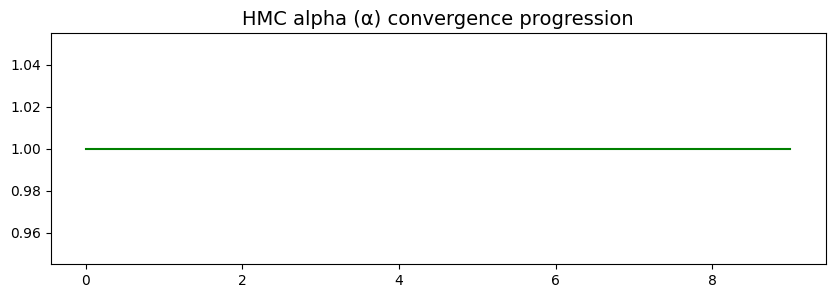

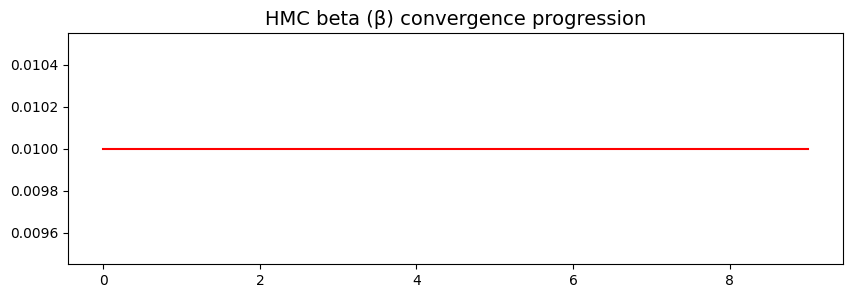

In [ ]:
# plotting the Posterior Samples
plt.figure(figsize=(10,3))
plt.plot(np.arange(number_of_steps), alpha, color='green')
plt.title('HMC alpha (α) convergence progression', fontsize=14)

plt.figure(figsize=(10,3))
plt.plot(np.arange(number_of_steps), beta, color='red')
plt.title('HMC beta (β) convergence progression', fontsize=14)

In [ ]:
t = posterior_predictive_samples_.reshape(number_of_steps,2)